# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    if verbose:
        print(f"There are {len(tokens)} tokens in the data.")
        print(f"There are {len(set(tokens))} unique tokens in the data.")
        print(f"There are {len(''.join(tokens))} characters in the data.")
        print(f"The lexical diversity is {len(set(tokens)) / len(tokens):.3f} in the data.")
        
    counts = Counter(tokens)
    
    if num_tokens > 0:
        print(counts.most_common(num_tokens))
    
    return [
        len(tokens),
        len(set(tokens)),
        len("".join(tokens)),
        len(set(tokens)) / len(tokens)
    ]


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # Filter out stopwords using predefined sw
    tokens = [token for token in tokens if token.lower() not in sw]
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
     # Split the text using the defined whitespace pattern
    tokens = whitespace_pattern.split(text)
    
    # Filter out any empty tokens
    tokens = [token for token in tokens if token]
    return(tokens)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [3]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/lvand/OneDrive/Desktop/Applied Text Mining/M2/M1 Assignment Data/M1 Results/" 
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [4]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [5]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [6]:
# Lyrics Data

lyrics_data = defaultdict(dict)

# Artist directories
for item in os.listdir(data_location + lyrics_folder):
    if os.path.isdir(data_location + lyrics_folder + item):
        # Lyric files
        for lyric_page in os.listdir(data_location + lyrics_folder + item):
            artist, song = lyric_page.split("_")
            song = song.replace(".txt", "")
            lyrics_data[item][song] = open(data_location + lyrics_folder + item + "/" + lyric_page).read()

# Process lyrics data
lyrics_df = pd.DataFrame.from_dict(
    {(artist, song): lyrics for artist, songs in lyrics_data.items() for song, lyrics in songs.items()},
    orient='index'
)
lyrics_df.columns = ['lyrics']

# Reset index to separate artist and song into columns
lyrics_df.reset_index(inplace=True)

# The first level of the multi-index will become columns and are renamed
lyrics_df.columns = ['artist_song', 'lyrics']
lyrics_df[['artist', 'song']] = lyrics_df['artist_song'].apply(pd.Series)
lyrics_df.drop(columns=['artist_song'], inplace=True)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [7]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Apply the pipeline techniques
lyrics_df['tokens'] = lyrics_df['lyrics'].apply(prepare, pipeline=my_pipeline)
lyrics_df['num_tokens'] = lyrics_df['tokens'].map(len)

# Process Twitter data
twitter_data["tokens"] = twitter_data["description"].apply(prepare, pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)


In [8]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [9]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1548484,cher,Sharing my home with Bonnie & Clyde who like s...,"[sharing, home, bonnie, clyde, like, sleepinge..."
225185,cher,JOSH OTIS. 💮. artist /model/internet sensation,"[josh, otis, 💮, artist, modelinternet, sensation]"
2112036,cher,So Flo ☀️ || FSW 💜,"[flo, ☀️, fsw, 💜]"
1712288,cher,NYC📍AEA | Classical Actor | Singer Rep: The Sq...,"[nyc📍aea, classical, actor, singer, rep, squar..."
2734363,cher,married to my G & we have our beautiful Lolli ...,"[married, g, beautiful, lolli, ❤️, love, twitt..."
1957354,cher,SF dweller. Desert native. Proud Mexicana. Sol...,"[sf, dweller, desert, native, proud, mexicana,..."
1041659,cher,❤🐕 why can't people be more like dogs?,"[❤🐕, cant, people, like, dogs]"
1048289,cher,MA/PA📍| Muhlenberg '21 🐴❤️ | Movin and Groovin...,"[mapa📍, muhlenberg, 21, 🐴❤️, movin, groovin, 💃🏻🔥]"
3919557,cher,Manchester United FC & Saints RLFC ❤️,"[manchester, united, fc, saints, rlfc, ❤️]"
2735072,cher,♥,[♥]


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: I believe that the emojis have the potential to be processed further. Processing the actual meaning of the emojis would provide a more granular look and enhance the sentiment scores, which could ultimatley provide more in depth analyses. There are also steps that can be taken beyond the regex expressions that will model context more effectively. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [10]:
# Print unique artist names for debugging
print("Unique artists in the DataFrame:")
print(lyrics_df['artist'].unique())

# Calculate descriptive statistics for each artist's lyrics
for artist in lyrics_df['artist'].unique():  # Iterate over unique artists
    artist_lyrics = lyrics_df[lyrics_df['artist'] == artist]  # Access lyrics for the artist
    all_tokens = [token for tokens in artist_lyrics['tokens'] for token in tokens]  # Flatten tokens into a single list
    
    print(f"\nDescriptive statistics for {artist}:")
    descriptive_stats(all_tokens, num_tokens=5, verbose=True)

Unique artists in the DataFrame:
['cher' 'robyn']

Descriptive statistics for cher:
There are 35916 tokens in the data.
There are 3703 unique tokens in the data.
There are 172634 characters in the data.
The lexical diversity is 0.103 in the data.
[('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333)]

Descriptive statistics for robyn:
There are 15227 tokens in the data.
There are 2156 unique tokens in the data.
There are 73787 characters in the data.
The lexical diversity is 0.142 in the data.
[('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 251)]


Q: what observations do you make about these data? 

A: Right away, it is obvious that Cher has significantly more tokens compared to Robyn. This could suggest that Cher's lyrics are more extensive, or reflect a larger body of work. This logic continues into the unique tokens and characters between the two artists as Cher also has over 1,000 more unique tokens and over 2 times more characters than that of Robyn's discography. Robyn does record a higher lexical diversity suggesting that she may be more experimental with her lyrics in relation to how many tokens are in her lyrics. The count of common words in Cher's lyrics suggest that a heavy theme in her music is love, while Robyn's themes may require more analysis to uncover more clearly.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [11]:
def calculate_frequencies(token_lists):
    # Flatten the list of token lists into a single list
    flat_tokens = [token for tokens in token_lists for token in tokens]
    frequency = Counter(flat_tokens)
    total_tokens = len(flat_tokens)
    return frequency, total_tokens

# Calculate frequencies for Twitter and Lyrics
twitter_freq, twitter_total = calculate_frequencies(twitter_data['tokens'])
lyrics_freq, lyrics_total = calculate_frequencies(lyrics_df['tokens'])

# Combine frequencies into a DataFrame
frequency_df = pd.DataFrame({
    'token': list(set(twitter_freq.keys()).union(set(lyrics_freq.keys()))),
    'twitter_count': [twitter_freq.get(token, 0) for token in set(twitter_freq.keys()).union(set(lyrics_freq.keys()))],
    'lyrics_count': [lyrics_freq.get(token, 0) for token in set(twitter_freq.keys()).union(set(lyrics_freq.keys()))]
})

# Set a cutoff to 5 for Robyn-Cher data
n = 5
filtered_df = frequency_df[(frequency_df['twitter_count'] >= n) & (frequency_df['lyrics_count'] >= n)]

# Create a copy of the filtered DataFrame to avoid errors of df splitting
filtered_df = filtered_df.copy()

# Calculate concentration based on above logic
filtered_df['twitter_concentration'] = filtered_df['twitter_count'] / twitter_total
filtered_df['lyrics_concentration'] = filtered_df['lyrics_count'] / lyrics_total

# Calculate concentration ratios
filtered_df['ratio'] = filtered_df['twitter_concentration'] / filtered_df['lyrics_concentration']

# Find top tokens for Twitter and Lyrics
top_twitter_tokens = filtered_df.nlargest(10, 'ratio')
top_lyrics_tokens = filtered_df.nsmallest(10, 'ratio')

# Display results
print("Top Tokens for Twitter:")
print(top_twitter_tokens[['token', 'twitter_count', 'lyrics_count', 'ratio']])

print("\nTop Tokens for Lyrics:")
print(top_lyrics_tokens[['token', 'lyrics_count', 'twitter_count', 'ratio']])

Top Tokens for Twitter:
          token  twitter_count  lyrics_count      ratio
347380   family          35789             6  15.780163
1285963   lover          64951            11  15.620910
1314945    wife          37979             8  12.559337
541132       en          30803             7  11.641479
1661652       2          27831             7  10.518261
1234926     que          27468             8   9.083437
242317   single          16202             5   8.572585
915598       mi          15175             5   8.029192
384541       la          44123            15   7.781923
1324038  follow          67736            25   7.167913

Top Tokens for Lyrics:
           token  lyrics_count  twitter_count     ratio
1159370     deng            32              7  0.000579
962301      ooga            38             11  0.000766
1295028   doodoo            28             12  0.001134
593364    holdin            29             13  0.001186
391437    gunman            10              5  0.001323


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Firstly, it is clear that the ratio for the top Twitter tokens are significantly larger than that of the lyrics dataa due to the twitter_count of each word. Within the top tokens for Twitter, we see that there are words in different languages, suggesting that Twitter is representation of multiple different cultures and ethnicities. In contrast, in the top tokens for the lyrics, we see truncated words such as "cryin", "holdin", and "shoppin" are common, likely due to the flow and lyricism within the artists songs. Overall, there does not appear to be a strong relationship between the artists' discographies and the tweets of their followers.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [12]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

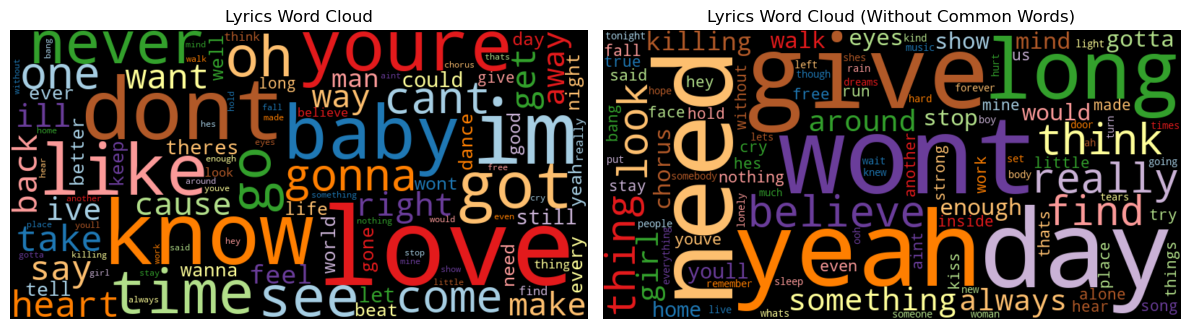

In [13]:
# word cloud of lyrics data
lyrics_freq_df = count_words(lyrics_df, column='tokens')
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
wordcloud(lyrics_freq_df['freq'], title='Lyrics Word Cloud', max_words=100)

plt.subplot(1, 2, 2)
wordcloud(lyrics_freq_df['freq'], title='Lyrics Word Cloud (Without Common Words)', 
          max_words=100, stopwords=lyrics_freq_df.head(50).index)

plt.tight_layout()
plt.show()

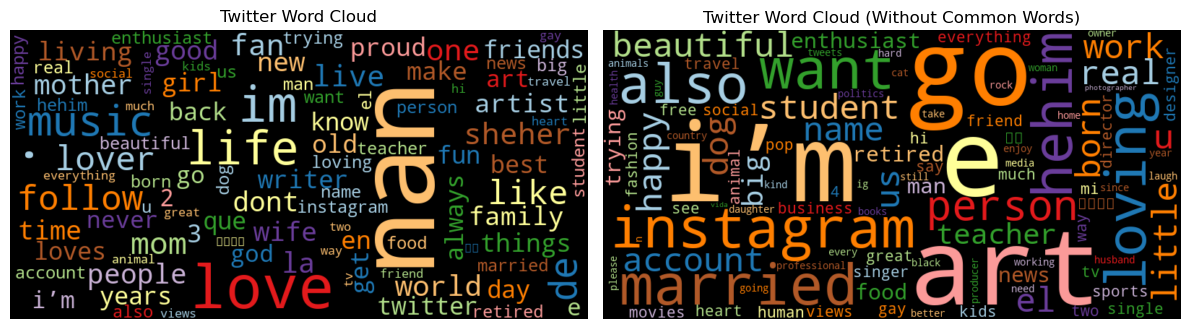

In [14]:
# word cloud of twitter data
twitter_freq_df = count_words(twitter_data, column='tokens')
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
wordcloud(twitter_freq_df['freq'], title='Twitter Word Cloud', max_words=100)

plt.subplot(1, 2, 2)
wordcloud(twitter_freq_df['freq'], title='Twitter Word Cloud (Without Common Words)', 
          max_words=100, stopwords=twitter_freq_df.head(50).index)

plt.tight_layout()
plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Even when using the stopwords within the function, it still seems that many "common" words are still coming through in the second word cloud in both the lyrics data and the twitter data. I would infer that this suggests a like of variety in both of these corporas, leaving common words like "i'm, go, yeah" within the word cloud. I personally don't believe that either set of word clouds show a vast difference in context of the corporas.